In [1]:
import ROOT, rat
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 
import jp_mpl as jplot
import geo_studies, rat_misc
from scipy import ndimage
reload(rat_misc)
from scipy import signal
from matplotlib.colors import LogNorm
from detect_peaks import detect_peaks
import pickle, scipy
from copy import deepcopy

TClass::TClass:0: RuntimeWarning: no dictionary for class omtext is available


In [2]:
# Airplane mode
db = rat.RAT.DB.Get()
db.SetAirplaneModeStatus(True)
db.SetDefaultPlaneLockStatus(False)
print 'This is AIRPLANE MODE - be careful!'

This is AIRPLANE MODE - be careful!


TClass::TClass:0: RuntimeWarning: no dictionary for class RAT::DBTableKey is available


In [3]:
socdir = '/sb/project/qbs-015-ac/jpyanez/data/SOC_files'
peakdir = '/sb/project/qbs-015-ac/jpyanez/data/SOC_peak_files'

In [4]:
bin_width = 0.5
npmts = 9728

In [5]:
def getTimeDiff(time_array,
                bin_width=0.5,
                time_window= 85.,
                plot_twindow = 120, # in ns, plotting only
                plot = False,
                debug = False):

    #### Peak based algorithm ####
    
    # Bin the ToA
    ybins  = np.linspace(time_array.mean()-50., 
                         time_array.mean()+150, 
                         (200/bin_width)+1)
    n1, x1 = np.histogram(time_array, ybins)
    # The highest peak is easy
    highest_peak_time = x1[n1.argmax()]

    
    # Bin ToA in a smaller range
    ybins = np.linspace(highest_peak_time - 20,
                        highest_peak_time + time_window,
                        (20+time_window)/bin_width + 1)
    n2, x2 = np.histogram(time_array, ybins)
    smooth_coeff = 1./bin_width
    
    nsmooth = ndimage.filters.gaussian_filter1d(n2, sigma=smooth_coeff)
    nsmooth[nsmooth<=0] = 1

    # Peak finding algorithm
    peaks = detect_peaks(nsmooth, 
                         mpd = 10*smooth_coeff,
                         edge='rising',show=False, mph=1.1)
    
    if peaks.size == 0:
        return -1, -1
    
    # Obtain the latest peak
    latest_peak = peaks[ybins[peaks].argmax()]
    # Getting the time difference between highest ones
    tdiff_peak = ybins[latest_peak] - highest_peak_time
    
    
    #### Derivative based algorithm ####
    
    # Finding the peaks of the derivative
    dx = (ybins[1]-ybins[0])/2.
    ydn = ybins[1:-1]
    dn = np.diff(np.log10(n2))/dx
    
    # Derivating, and smoothing over it
    dnsmooth = np.diff(np.log10(nsmooth))/dx  
    dnsmooth = ndimage.filters.gaussian_filter1d(dnsmooth, 
                                                 sigma=smooth_coeff)
    # Highest peak is easy
    highest_dpeak_time = ydn[dnsmooth.argmax()]

    # Finding the peaks
    dpeaks = detect_peaks(dnsmooth, mpd = 10*smooth_coeff,
                          edge='rising',show=False, mph=0.1)
    
    if dpeaks.size == 0:
        return -1, -1

    # Obtain the latest peak
    latest_dpeak = dpeaks[ydn[dpeaks].argmax()]
    # Getting the time difference between highest ones
    tdiff_dpeak = ydn[latest_dpeak] - highest_dpeak_time

    if plot:
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(211)
        jplot.unfilledBar(x1, n1, color='0.7')
        jplot.unfilledBar(ybins, nsmooth, color='red')
        plt.yscale('log')
        plt.plot((ybins[peaks]+ybins[peaks-1])/2., 
                 nsmooth[peaks], 'xg')
        plt.ylabel('N hits')

        plt.axvline(x = ybins[latest_peak], ymin=0, ymax = n1.max()*1.2, 
                    linestyle='--', color='k')
        plt.axvline(x = highest_peak_time, ymin=0, ymax = n1.max()*1.2, 
                    linestyle='--', color='k')


        ax2 = fig.add_subplot(212,sharex=ax1)
        plt.plot(ydn, dn, color='0.7')

        plt.plot(ydn, dnsmooth, color = 'red')
        plt.subplots_adjust(hspace=0.)
        plt.xlim(time_array.mean()-20, time_array.mean()+plot_twindow)

        plt.plot((ydn[dpeaks]+ydn[dpeaks-1])/2., 
                  dnsmooth[dpeaks], 'xg')
        plt.axvline(x = ydn[latest_dpeak], ymin=0, ymax = dnsmooth.max()*1.2, 
                    linestyle='--', color='k')
        plt.axvline(x = highest_dpeak_time, ymin=0, ymax = dnsmooth.max()*1.2, 
                    linestyle='--', color='k')
        plt.ylabel('dN/dt')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.xlim(np.min([highest_peak_time, highest_dpeak_time])-7,
                 np.max([ydn[latest_dpeak], ybins[latest_peak]]) + 10)
        return fig
    
        #raw_input()
    return tdiff_peak, tdiff_dpeak

In [6]:
infile_list = os.listdir(socdir)
#for i, x in enumerate(infile_list): print i, x 

## Testing a handful of PMT for all files - prerequisite!

Run already done, skipping it SOC_0000017375_reprocessed.root
Run already done, skipping it SOC_0000017376_reprocessed.root
Run already done, skipping it SOC_0000017377_reprocessed.root
Run already done, skipping it SOC_0000017378_reprocessed.root
Run already done, skipping it SOC_0000017384_reprocessed.root
Run already done, skipping it SOC_0000017386_reprocessed.root
Run already done, skipping it SOC_0000100554.root
Run already done, skipping it SOC_0000100555.root
Doing  0000100556
Doing  0000100558
Run already done, skipping it SOC_0000100559.root
Run already done, skipping it SOC_0000100560.root
Run already done, skipping it SOC_0000101152.root
Run already done, skipping it SOC_0000101153.root
Run already done, skipping it SOC_0000101154_000.root
Run already done, skipping it SOC_0000101154_001.root
Run already done, skipping it SOC_0000101154_002.root
Run already done, skipping it SOC_0000101154_003.root
Run already done, skipping it SOC_0000101154_004.root
Run already done, skip

/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log10


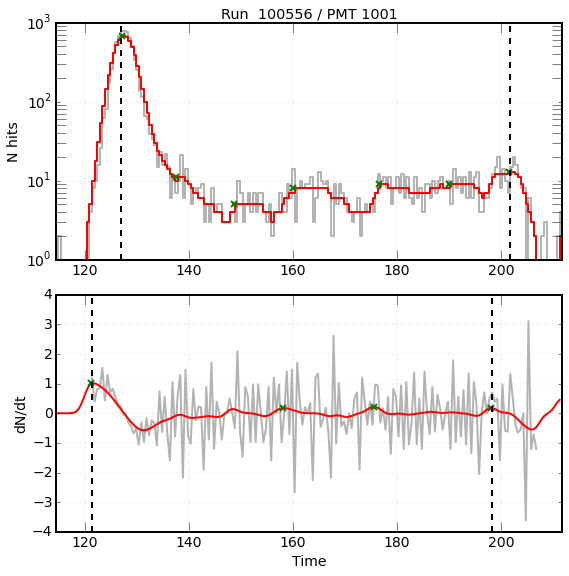

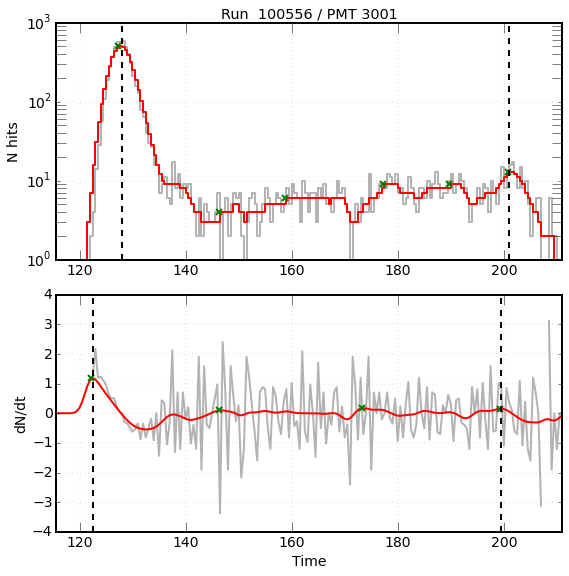

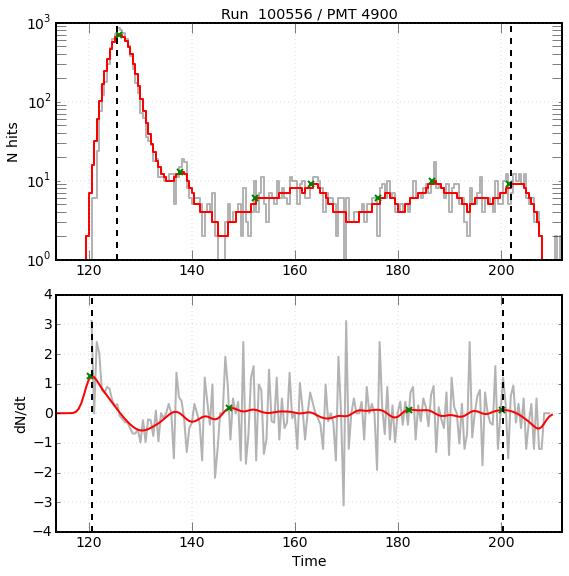

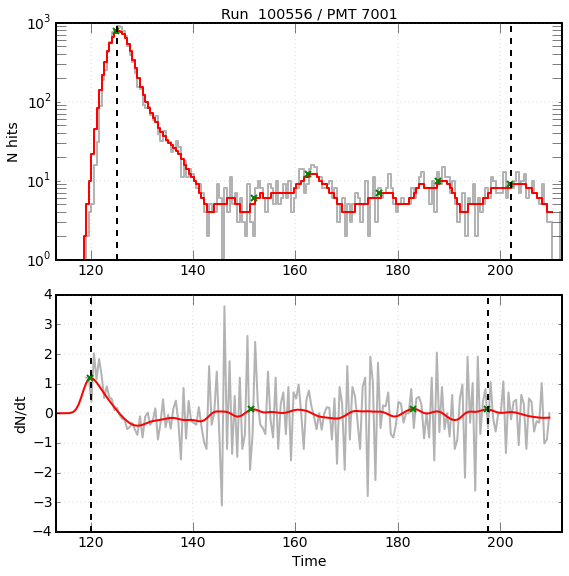

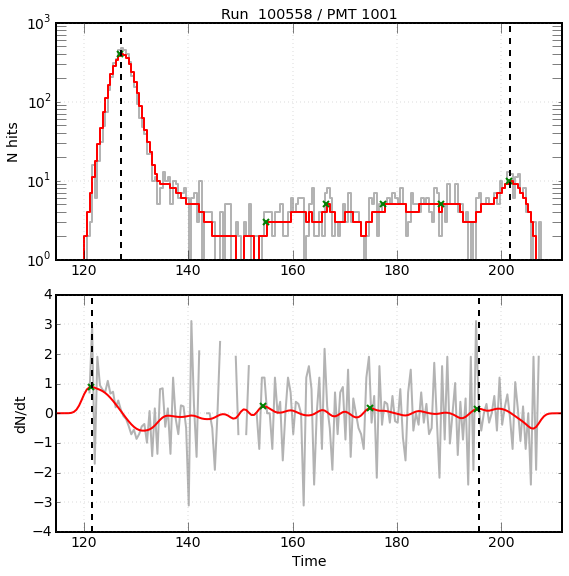

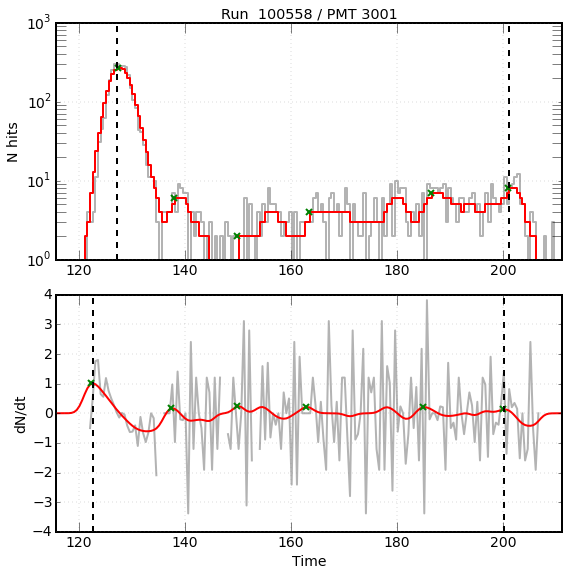

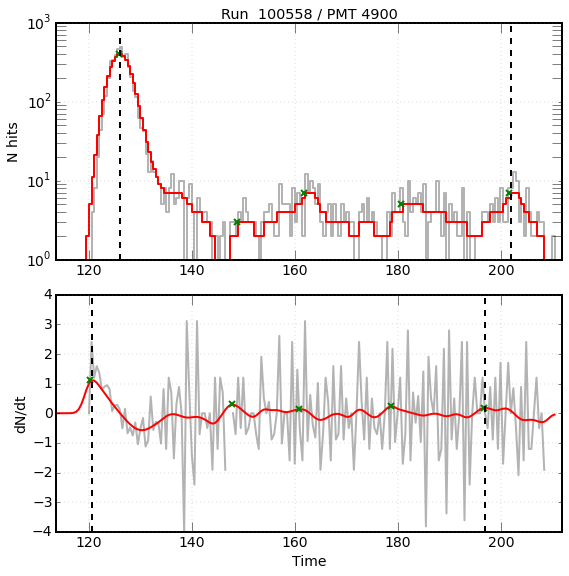

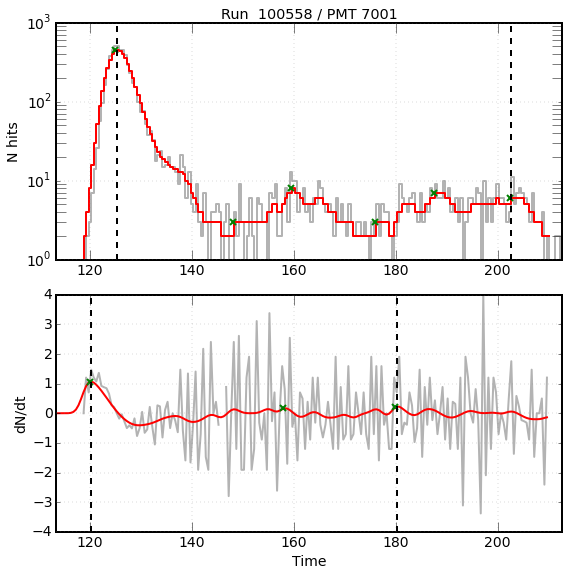

In [62]:
pmt_list = [1001, 3001, 4900, 7001]
figs_path = '/home/jpyanez/snoplus/data/SOC_peak_verification/'
for one_infile in infile_list:
    infile_name = os.path.join(socdir, one_infile)
    infile_stripped = one_infile.lstrip('SOC_').rstrip('.root').rstrip('_newPCA').rstrip('_reprocessed')
    
    if os.path.isfile(figs_path + infile_stripped  + 
                      '_' + "%i" % pmt_list[0] + '.png'):
        print 'Run already done, skipping it', one_infile
        continue
    else:
        print 'Doing ', infile_stripped
    reader = rat.socreader(infile_name)
    soc, run = reader.next()
    soc.GetRunID()
    soc_pmts = np.array(soc.GetSOCPMTIDs())
    for one_pmt in pmt_list:
        time_array = np.array(soc.GetSOCPMT(one_pmt).GetTimes())
        time_array[time_array<0] = 0.
        try:
            thisfig = getTimeDiff(time_array,  plot=True)
            axes = thisfig.get_axes()
            axes[0].set_title('Run  '+ "%i" % soc.GetRunID() + ' / PMT ' + "%i" % one_pmt,
                             size='x-large')
            thisfig.savefig(figs_path + infile_stripped  + 
                            '_' + "%i" % one_pmt + '.png')
        except:
            print 'Something went wrong', soc.GetRunID(), one_pmt

 ## Verify the output before moving forward!

In [7]:
# Sadly, the verification is done by hand
usable_run_list =  [17375,
100556,
100558,
101427,
101428,
101432,
101433,
102518,
102529,
102552,
102554,
102570,
102572,
102574]

In [1]:
# Remove useless runs from file list
original_infile_list = os.listdir(socdir)
infile_list = []
for one_file in original_infile_list:
    for usable_run in usable_run_list:
        if "%i" % usable_run in one_file:
            infile_list.append(one_file)
            break
            
print 'List of good run files'
infile_list

NameError: name 'os' is not defined

## Running over all the files

In [12]:
while len(infile_list) > 0:
    one_file = infile_list[0]
    data = None
    # Need to establish if the file has subfiles
    run_number = one_file[:14]
    new_list   = []
    for one_name in infile_list:
        if run_number in one_name:
            new_list.append(one_name)
    for one_name in new_list:
        infile_list.remove(one_name)
        
    
    #print run_number
    #print 'New list', new_list
    #print infile_list
    #continue
            
    reader_list = []
    soc_list = []
    zero_counter = 0
    skip_counter = 0
    soc_pmts = np.array([0])
    already_processed = False
    for i, this_name in enumerate(new_list):
        infile_name = os.path.join(socdir, this_name)
        
        if i == 0:
            print 'Run', this_name, ' - Subruns', len(new_list)
            outfile_name = os.path.join(peakdir, run_number + '.pckl')
            if os.path.isfile(outfile_name):
                print 'Run already processed. Skipping it ...'
                already_processed = True
                break
            else:
                print outfile_name
                
        
        # Need to open all the readers
        reader_list.append(rat.socreader(infile_name))
        this_soc, this_run = reader_list[-1].next()
        soc_list.append(this_soc)
        soc_pmts = np.concatenate((soc_pmts, np.array(this_soc.GetSOCPMTIDs())))

        if i == 0:
            # Get the basic info from the first file
            manip_pos = np.array(this_soc.calib.GetPos())
            fit_pos  = np.array(this_soc.GetFitResult(this_soc.GetFitNames()[0]).GetVertex(0).GetPosition())

            data = {'manip_pos':manip_pos,
                    'fit_pos':fit_pos,
                    'soc_pmts':soc_pmts}
    
            delta_ts = np.zeros([npmts, 2])
            poccupancy = np.zeros(npmts)
            print 'Going over the ', len(soc_pmts), ' PMTs'
                              
    if already_processed:
        continue     

    soc_pmts = np.unique(soc_pmts)
        
    for ipmt, one_pmt in enumerate(soc_pmts):
        time_array = np.array([0])
        for isoc, soc in enumerate(soc_list):
            try:
                poccupancy[one_pmt] += soc.GetSOCPMT(one_pmt).GetPromptOccupancy()

                time_array = np.concatenate((time_array,
                                             np.array(soc.GetSOCPMT(one_pmt).GetTimes())))

                time_array[time_array < 0] = 0.
                if time_array.mean() == 0:
                    skip_counter += 1
                    continue
            except:
                print one_pmt
                print 'PMT problematic', one_pmt, new_list[isoc]
                continue
                
            if ipmt % 500 == 0:
                print ipmt,
                
        delta_ts[one_pmt, :] = getTimeDiff(time_array,
                                                bin_width = bin_width)
        if np.sum(delta_ts[one_pmt,:]) == 0:
            zero_counter += 1

    data['poccupancy'] = poccupancy
    data['delta_ts'] = delta_ts
    print 'Zero counter', zero_counter
    print 'Skip counter', skip_counter
    
    pickle.dump(data, open(outfile_name,'w'))
    
    for reader in reader_list:
        reader.close()

Run SOC_0000017375_reprocessed.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000100556.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000100558.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000101427_reprocessed_newPCA.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000101428_reprocessed_newPCA.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000101432_reprocessed_newPCA.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000101433_reprocessed_newPCA.root  - Subruns 1
Run already processed. Skipping it ...
Run SOC_0000102518.root  - Subruns 1
/sb/project/qbs-015-ac/jpyanez/data/SOC_peak_files/SOC_0000102518.pckl
Going over the  9341  PMTs
500 1000 1500 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 Zero counter 622
Skip counter 776
Run SOC_0000102529.root  - Subruns 1
/sb/project/qbs-015-ac/jpyanez/data/SOC_peak_files/SOC_0000102529.pckl
Going over the  935

/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: RuntimeWarning: divide by zero encountered in log10
/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/Python/2.7.10/lib/python2.7/site-packages/numpy/lib/function_base.py:1114: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]
